In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from capstone.util import load_kospi_data, load_dataset
import os
import warnings

from matplotlib import ticker
warnings.filterwarnings(action='ignore')
import networkx as nx
import community as community_louvain

In [128]:
pickle_path = './pickle'
kospi_path = './data/kospi200_stocks.xlsx'

interest_rate_increase = {
    "name" : 'interest_rate_increase',
    "start_date" : '2020-01-01',
    "end_date": '2022-03-01'
}
yield_curve_inversion = {
    "name" : "yield_curve_inversion",
    "start_date" : '2018-01-01',
    "end_date": '2019-12-01'
}

In [129]:
kospi_pickle_path = pickle_path + '/kospi_data.pickle'
kospi_data = load_kospi_data(kospi_pickle_path,kospi_path)

In [130]:
interest_rate_pickle_path = pickle_path + f'/{interest_rate_increase["name"]}.pickle'
yield_curve_pickle_path = pickle_path + f'/{yield_curve_inversion["name"]}.pickle'

In [131]:
df_interest_rate = load_dataset(kospi_data,interest_rate_pickle_path,interest_rate_increase['start_date'],interest_rate_increase['end_date'])

In [132]:
df_yield_curve = load_dataset(kospi_data,yield_curve_pickle_path,yield_curve_inversion['start_date'],yield_curve_inversion['end_date'])

## 군집화 기간 1년

In [133]:
test_df = df_interest_rate[:'2021-01-01']
validation_df = df_interest_rate['2021-01-02':]

In [134]:
from modularity.calculate_modularity import calculate_louvain
from community import community_louvain

partition,G = calculate_louvain(test_df,threshold=0.3)
modularity_value = community_louvain.modularity(partition,G)

In [135]:
print(f"MODULARITY : {modularity_value}")

MODULARITY : 0.2015448118363189


In [136]:
n_clusters = len(set(partition.values()))
print(f"클러스터 갯수 : {n_clusters}")

# 클러스터 개수만큼 딕셔너리 생성
dict_clusters = {i : [] for i in range(n_clusters)}

클러스터 갯수 : 3


In [137]:
# 클러스터 기준으로 군집 분류 
for stock_code,cluster in partition.items():
    dict_clusters[cluster].append(stock_code)

In [138]:
# 각 군집별로 데이터프레임 생성
clusters_list = []
for cluster in dict_clusters.keys():
    clusters_list.append(test_df[dict_clusters[cluster]])

In [139]:
# validation 각 군집별로 데이터프레임 생성
val_clusters_list = []
for cluster in dict_clusters.keys():
    val_clusters_list.append(validation_df[dict_clusters[cluster]])

In [140]:
test_cluster = clusters_list[1].pct_change().dropna()

In [141]:
mean_returns = test_cluster.mean()
cov_matrix = test_cluster.cov()

In [142]:
from capstone.portfolio_model import mean_variance_portfolio
weight = mean_variance_portfolio(mean_returns, cov_matrix)
weight

array([0.00000000e+00, 3.88958059e-12, 8.99649852e-14, 9.79139772e-14,
       9.56343912e-17, 9.90454051e-16, 5.79908951e-13, 0.00000000e+00,
       4.60526361e-14, 2.85900024e-16, 4.36610502e-17, 6.07210229e-16,
       1.98478733e-13, 2.45058224e-13, 1.10427173e-15, 2.33715582e-14,
       0.00000000e+00, 6.64872528e-13, 0.00000000e+00, 5.79735829e-14,
       1.05815019e-15, 3.77396012e-13, 6.16110107e-17, 4.22121454e-13,
       2.09710555e-16, 3.04257977e-16, 4.07230369e-16, 4.51629596e-16,
       1.55985753e-16, 6.87022320e-18, 4.55323560e-16, 0.00000000e+00,
       2.70206152e-13, 9.69782898e-13, 0.00000000e+00, 2.41194021e-16,
       7.55027709e-13, 6.69375864e-16, 4.47542951e-13, 2.21161950e-13,
       2.34316950e-13, 5.06657264e-16, 1.54229110e-13, 6.62678892e-14,
       0.00000000e+00, 2.44731376e-13, 0.00000000e+00, 5.23500397e-13,
       2.56709733e-13, 5.09452897e-16, 5.96109769e-13, 3.65547279e-16,
       8.18605272e-13, 0.00000000e+00, 1.32356999e-16, 2.60674241e-13,
      

In [143]:
val_cluster_1_return = val_clusters_list[1].pct_change().dropna()

In [144]:
result = val_cluster_1_return @ weight

In [145]:
result

Date
2021-01-03    0.000000
2021-01-04    0.052336
2021-01-05    0.012433
2021-01-06   -0.043860
2021-01-07    0.022018
                ...   
2022-02-25    0.039886
2022-02-26    0.000000
2022-02-27    0.000000
2022-02-28    0.063014
2022-03-01    0.000000
Length: 423, dtype: float64

In [146]:
df_profit_accumulate = (1+result).cumprod()-1

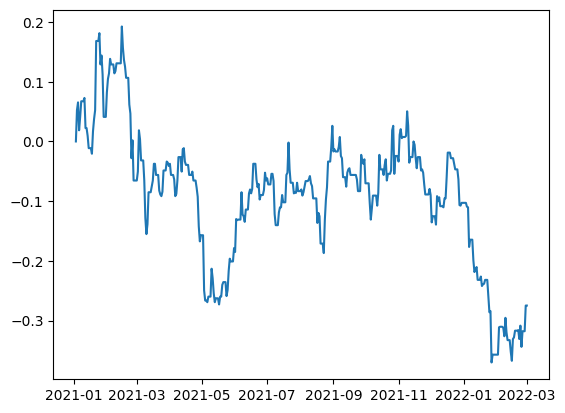

In [147]:
plt.plot(df_profit_accumulate)